# Table of Contents
1. [Introduction](#intro)
2. [Preprocessing](#preprocessing)
3. [Feature Engineering](#features)
4. [Encoding](#encoding)
5. [Models](#models)
5. [Conclusions](#conclusions)

# <a class="anchor" id="intro">1. Introduction</a>
<b>What is Kiva?</b><br>
Kiva is a crowdfunding platform designed to help 3rd world countries, it helps the people get with loans for any reason, but is mostly trying to help with social and environmental issues. The platform isn't limited for collective issues, but helps individuals with their cause, for example, buying seeds and fertilizer for a farm, assist with school tution and buying building materials. <br>
Borrowers ask for money for their cause, the borrow request is done via a Field Agent, who reviews the request and upload it to the site. After a borrow request has been published, people can fund it in increments of $25. Then the borrower has to refund the money by the agreed upon date. The money is returned to the borrowers and they can fund another project. <br>
Kiva is a non-profit organization, the borrowers don't get interest from their loan. <br>
<br><br>
<b>Our goal</b><br>
Helping Kiva to predict how likely a loan is to be funded. We will be using a labeled dataset (our ground truth mechanism is described below under the "labeling" sub section). 
We trained a few models for evaluation, and also tested using an external dataset (the "MPI" dataset) to better understand his/her financial background and to help lenders and Kiva invest wisely.


## 1.1 Motivation
Kiva is an online crowdfunding platform to extend financial services to poor and financially excluded people around the world. Kiva lenders have provided over $1 billion dollars in loans to over 2 million people. In order to set investment priorities, help inform lenders, and understand their target communities, knowing the level of poverty of each borrower is critical. However, this requires inference based on a limited set of information for each borrower.

## 1.2 Data
1. We decided to go on with [this challenge](https://www.kaggle.com/kiva/data-science-for-good-kiva-crowdfunding) due to its publish on kaggle.com
2. The [MPI datasets](https://www.kaggle.com/ophi/mpi) are also used in this notebook and available through Kaggle.

## 1.3 Tools
- pandas, numpy
- sklearn (MLPClassifier, SGDClassifier)
- matplotlib
- seaborn
- imblearn and other clustering tools
- geopy
- tranlsate
- SequenceMatcher

# <a class="anchor" id="preprocessing">2. Preprocessing</a>

## 2.1 Loading the data

In [1]:
import pandas as pd
import numpy as np
import math
import nltk
# Download if isn't installed
#nltk.download()
from nltk.tokenize import RegexpTokenizer
from tqdm import tqdm
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    tqdm.pandas()

print("loading...")
loans = pd.read_csv(r"datasets/kiva_loans.csv")
mpi_region = pd.read_csv(r"datasets/MPI_subnational.csv")
mpi_country = pd.read_csv(r"datasets/MPI_national.csv")
print("loaded.")

loading...
loaded.


## 2.2 Missing values

Before dwelving into the dataset, lets check how complete the dataset is.

### 2.2.1 Missing values in %

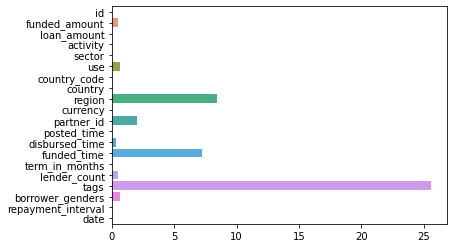

In [2]:
import seaborn as sns

missing_data_in_rows = dict()
for key in loans.keys():
    data = loans[key]
    count = 0
    for line in data:
        if not line or (type(line) == float and math.isnan(line)):
            count += 1
    missing_data_in_rows[key] = count/len(loans)*100
    #print(f'{key}: {count/len(loans)*100}% ({count}/{len(loans)})')# ({missing_data_in_rows[key]}/{count})')
    
keys = list(missing_data_in_rows.keys())
values = [missing_data_in_rows[k] for k in keys]
sns.barplot(y=keys, x=values)

### 2.2.2 Handling missing values
* funded_time - missing value actually means that it's an unsuccessful loan, so they will be labeled later as unsuccessful. no issue here.
* tags - we extract later features out of this field, doesn't necesserily need to be in all the samples. no issue here.
* borrower_genders - handled below in the feature engineering section.
* region - will be handled later in a dedicated chapter.
* partner_id - the missing values will be filled with 0.
* lender_count - the missing values will be filled with 0.
* country_code - the missing values will be filled with na.
* use - the missing values will be filled with an empty string.

In [3]:
def fill_missing_values(field, value):
    missing_values_before = loans[field].apply(lambda x: 1 if type(x) is float and math.isnan(x) else 0).sum()
    loans[field] = loans[field].fillna(value)
    missing_values_after = loans[field].apply(lambda x: 1 if type(x) is float and math.isnan(x) else 0).sum()
    print(f'Missing values in {field} - before: {missing_values_before}, after: {missing_values_after}')

fill_missing_values('partner_id', 0)
fill_missing_values('lender_count', 0)
fill_missing_values('country_code', 'na')
fill_missing_values('use', '')

Missing values in partner_id - before: 13507, after: 0
Missing values in lender_count - before: 0, after: 0
Missing values in country_code - before: 8, after: 0
Missing values in use - before: 4232, after: 0


## 2.3 Regional MPI
Our data consists of Loans, National MPI and Regional MPI. Each loans states the region of the borrower, and we can use this data in our advance. <br>
The region column on the loans dataset has a lot of unique values, which does not represnt a region directly, some of the entries contain cities or district, and other have more data than just a region or a city. 
If we'd like to use the regional MPI data set, we need to extract the region (and only the region) for each entry. <br>
In order to use this data, we'll need to split cluttered entries and "zooming out" to get the region for most of the entries. Additionally, some countries does not have Regional MPI data for us to use. <br>

### 2.3.1 Reviewing loans region column

In [4]:
missing = set()
for region in loans.region.unique(): #what if there are 2 different regions from different countries but with the same name?
    if region not in mpi_region['Sub-national region'].values:
        missing.add(region)
print(f"Amount of missing regions: {len(missing)}")

Amount of missing regions: 12561


Translating city to region won't be an easy job, considering all the different countries. An easier approach would be fixing the larger chunk of data, doing the least job. So we'll find out how many entries we have for each country.

In [5]:
loans_geo_df = loans.groupby(['country','region']).size().reset_index(name='Freq')
loans_geo_country_df = loans.groupby(['country']).size().reset_index(name='Freq')

mpi_df = mpi_region[['Country', 'Sub-national region']] 
mpi_df = mpi_df.rename(columns={'Country': 'country', 'Sub-national region': 'region'})
loans_geo_with_mpi_df = loans_geo_df.merge(mpi_df, indicator=True, how='outer', on=(['country', 'region']))
loans_geo_country_with_mpi_df = loans_geo_with_mpi_df.groupby(['country']).sum().sort_values('Freq', ascending=False)

missing_regions = int(loans_geo_with_mpi_df[loans_geo_with_mpi_df['_merge'] == 'left_only']['Freq'].sum())
missing_regions_top10 = int(loans_geo_country_with_mpi_df[:10].sum()['Freq'])

print(f"Amount of loans with missing regions: {missing_regions}")
print(f"Only in the top 10: {missing_regions_top10}")
print(f"{missing_regions_top10/missing_regions*100}%\n")
print(loans_geo_country_with_mpi_df[:10])

Amount of loans with missing regions: 559731
Only in the top 10: 405367
72.42175259187003%

                 Freq
country              
Philippines  160360.0
Kenya         67073.0
Cambodia      34811.0
Pakistan      26852.0
Peru          22073.0
Colombia      21218.0
Uganda        20390.0
El Salvador   19624.0
Tajikistan    19482.0
Ecuador       13484.0


We have total of 671205 loan entries. 563450 of them has a corrupted region info. Fixing the top 10 countries on that list would fix 72% of the total regions. Fixing each country can be a tedious job for some countries (Kenya for example, due to lack of useful, easy to use, data online), and even when addressing a country individually, we still won't hit 100% success.
Instead, we tried addressing the problem as a whole, and using some tools and some time we managed to get some nice results.
We decided to fill the missing MPI data with 0s.

### 2.3.2 Reviewing missing countries in regional MPI
Let see which contries don't have regional MPI data, and total of how many entries don't have the relevant data.

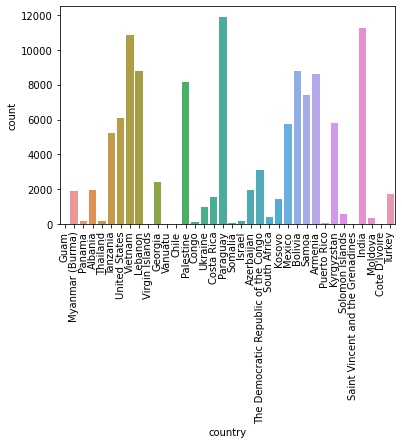

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
countries = set(loans['country'].unique()) - set(mpi_region['Country'].unique())
ax = sns.countplot(loans.country, order=countries)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

In [7]:
contries_count = loans.groupby('country').size()
print(f'In total, we have {len(countries)} countries without regional MPI data, which means we have {contries_count[countries].sum()} non resolvable entries. \nWhich means {contries_count[countries].sum()/len(loans)*100:.02f}% of our data is non-resolvable')

In total, we have 36 countries without regional MPI data, which means we have 117627 non resolvable entries. 
Which means 17.52% of our data is non-resolvable


### 2.3.3 Fixing regions data
Our first method was resolved each country individually, or to do so for the 10 most common countries in the Kiva loans dataset. First we started resolving the Philippines. It has a slightly complex divisioning system, and most of the entries have more data then just the region itself, but we managed to resolved 95% of the entries (which means 10k unresolved entries). <br>
After the Philippines we started resolving Kenya. They have regions, but most of the data on the loans dataset is small villages, which sometimes fail to yield result even on google. resolving all of the villages one by one would've been a tedious job, so we gave up on that method. <br>
Our current method is using geopy + translate + SequenceMatcher to find the best result. <br>
The region_resolver script can be find outside of this notebook. It needs several hours to run, but it yields decent results. Geopy returns location tokens, then we translate the token, because some of them are in foreign languages, and then we take the region of the same country with a match of 85% or more using sequence matcher.


#### 2.3.3.1 Applying the results on the Dataset

In [8]:
import json
with open(r"datasets/regions.json", 'r') as fp:
    _, resolved_regions = json.load(fp).values()

def region_solver(x):
    if pd.isna(x.region):
        return 0
    new_region = resolved_regions[f'{x.country}, {x.region}']
    if isinstance(new_region, int):
        return 0
    return new_region
    
resolved = loans.progress_apply(region_solver, axis=1)
loans['region_new'] = resolved

100%|███████████████████████████████████████████████████████████████| 671205/671205 [00:43<00:00, 15499.81it/s]


In [9]:
resolved_count = pd.DataFrame(resolved).groupby(0).size()
total_resolved = resolved_count.sum() - resolved_count[0]
print(f'We have resolved regions for {total_resolved} entries out of {resolved_count.sum()} which is {total_resolved/resolved_count.sum() * 100:.2f}%')

We have resolved regions for 311366 entries out of 671205 which is 46.39%


#### 2.3.3.2 Merging with MPI regional & Fix missing values

In [10]:
loans_with_region_df = loans.query("region_new != 0")
loans_without_region_df = loans.query("region_new == 0")

loans_with_region_df = pd.merge(loans_with_region_df, mpi_region, left_on=['country','region_new'], right_on=['Country', "Sub-national region"])

loans = pd.concat([loans_with_region_df, loans_without_region_df])

fill_missing_values('MPI National', 0)
fill_missing_values('MPI Regional', 0)
fill_missing_values('Headcount Ratio Regional', 0)
fill_missing_values('Intensity of deprivation Regional', 0)

Missing values in MPI National - before: 359839, after: 0
Missing values in MPI Regional - before: 359839, after: 0
Missing values in Headcount Ratio Regional - before: 359839, after: 0
Missing values in Intensity of deprivation Regional - before: 359842, after: 0


We've resovled almost 50% of the regions data. It's not perfect, but it adds a lot of data and probaly gives us more information than resolving a few countries individually. 

## 2.4 Country MPI
Here we join the country data from the MPI data. The MPI dataset was explained at the beginning of the notebook.

In [11]:
loans = pd.merge(loans, mpi_country, right_on='Country', left_on='country', how="left")

### 2.4.1 Fixing missing values

In [12]:
fill_missing_values('MPI Urban', 0) 
fill_missing_values('MPI Rural', 0)
fill_missing_values('Headcount Ratio Urban', 0)
fill_missing_values('Headcount Ratio Rural', 0)
fill_missing_values('Intensity of Deprivation Urban', 0)
fill_missing_values('Intensity of Deprivation Rural', 0)

Missing values in MPI Urban - before: 80765, after: 0
Missing values in MPI Rural - before: 80765, after: 0
Missing values in Headcount Ratio Urban - before: 80765, after: 0
Missing values in Headcount Ratio Rural - before: 80765, after: 0
Missing values in Intensity of Deprivation Urban - before: 80765, after: 0
Missing values in Intensity of Deprivation Rural - before: 80765, after: 0


## 2.5 Labeling
### 2.5.1 Amounts and labeling
We will classify the loans into 2 categories - 
1. Successful - A loan which has been fully funded by Kiva lender,
2. Unsuccessful - A partialy funded loan.
<br>

The label will be based on the following condition:<br>
loan_amount - funded_amount == 0


unsuccessful loans: 48328, successful loans: 622875


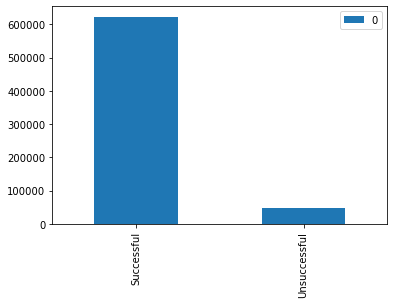

In [13]:
import seaborn as sns

unsuccessful_loans_df = loans[loans['funded_amount'] < loans['loan_amount']]
successful_loans_df = loans[loans['funded_amount'] == loans['loan_amount']]
print(f'unsuccessful loans: {len(unsuccessful_loans_df)}, successful loans: {len(successful_loans_df)}')

ax = pd.DataFrame([len(successful_loans_df), len(unsuccessful_loans_df)], index=["Successful", "Unsuccessful"]).plot(kind="bar")

In [18]:
successful_loans_df.loc[:,'Key'] = 'Successful'
unsuccessful_loans_df.loc[:,'Key'] = 'Unsuccessful'
loans_with_label = pd.concat([successful_loans_df, unsuccessful_loans_df]).reset_index(drop=True)

### 2.5.2 Dealing with imbalanced data
As it can be seen, the data isn't balanced, since (fortunately) most of the loans were successfully funded. <br>
We present 3 different techniques to deal with it:<br>
- <b>reduction of the succesful samples</b> - since there are less unsuccessful samples, an appropriate approach is not to use all the successful loans data.
- <b>oversampling</b> - duplication of existing unsuccessful samples in order to enlarge the data set size.using imbalance datasets
- <b>using imbalanced data sets</b> - by that taking more successful loans than unsuccessful loans. The simplest approach, but might lead to biases (the results were bad, so won't be presented here).


#  <a class="anchor" id="features">3. Feature engineering</a>
We will take fields from different columns and generate features from them. Some examples:
1. Tags - some interesting tags can produce a boolean feature (exists or not)
2. "is_funded" (boolean) - loan_amount - funded_amount == 0

## 3.1 Gender Features
We will extract 3 features: amount of borrowers, the existence of a feminine and the existence of a masculine.<br>
In case of missing value in the borrower_genders field, the values are defined as follows, correspondingly: 0, False, False.

In [19]:
loans_with_label['borrowers_amount'] = loans_with_label.apply(lambda r:len(r.borrower_genders.split(',')) if type(r.borrower_genders) is str else 0, axis=1)
loans_with_label['has_female'] = loans_with_label.apply(lambda r:'female' in r.borrower_genders.split(',') if type(r.borrower_genders) is str else False, axis=1)
loans_with_label['has_male'] = loans_with_label.apply(lambda r:'male' in r.borrower_genders.split(',') if type(r.borrower_genders) is str else False, axis=1)

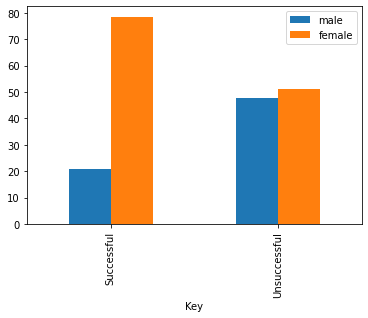

In [20]:
males_count = loans_with_label.groupby(['Key', 'has_male']).size().unstack('has_male')[True]
females_count = loans_with_label.groupby(['Key', 'has_female']).size().unstack('has_female')[True]
gender_df = pd.DataFrame([males_count, females_count], index=['male', 'female'])
gender_df["Successful"] = gender_df["Successful"].apply(lambda x: x / len(successful_loans_df) * 100)
gender_df["Unsuccessful"] = gender_df["Unsuccessful"].apply(lambda x: x / len(unsuccessful_loans_df) * 100)
ax = gender_df.transpose().plot(kind="bar")

 #### Results
 This barplot shows the percentage of loans with male and female borrowers in successful and unsuccessful loans separately

## 3.2 Loans use extraction
The use column contains free text for the lenders to descrive the purpose of their loan. <br> 
First we will take a quick look at the data using wordcloud to get the genreral idea for the usage of the loans, and what the lenders need the money for. <br>
And then we'll extract some features from the text.
### 3.2.1 Exploring
The use columns is a free text that describes the purpose of the loan, using a wordcloud can give the essence of successful and unsuucessful loans.

In [21]:
stop_words = set(nltk.corpus.stopwords.words('english')) 
tokenizer = RegexpTokenizer(r'\w+')
final = []
for use in successful_loans_df.use:
    if type(use) != str:
        continue
    tokenized = tokenizer.tokenize(use)
    filtered = [w.lower() for w in tokenized if w not in stop_words]
    final.extend(filtered)
#     final += " " + " ".join(filtered)
final_successful = " ".join(final)

stop_words = set(nltk.corpus.stopwords.words('english')) 
tokenizer = RegexpTokenizer(r'\w+')
final = []
for use in unsuccessful_loans_df.use:
    if type(use) != str:
        continue
    tokenized = tokenizer.tokenize(use)
    filtered = [w.lower() for w in tokenized if w not in stop_words]
    final.extend(filtered)
#     final += " " + " ".join(filtered)
final_unsuccessful = " ".join(final)

Word clound for successful loans


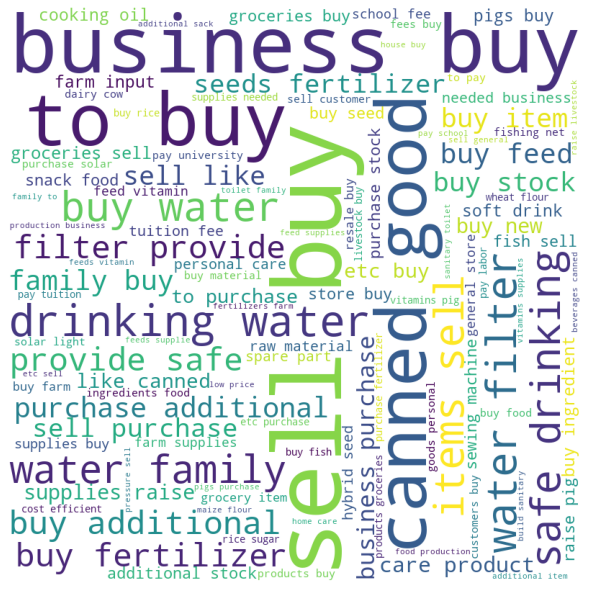

In [22]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stop_words, 
                min_font_size = 10).generate(final_successful)

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

print("Word clound for successful loans")

plt.show() 

Word clound for unsuccessful loans


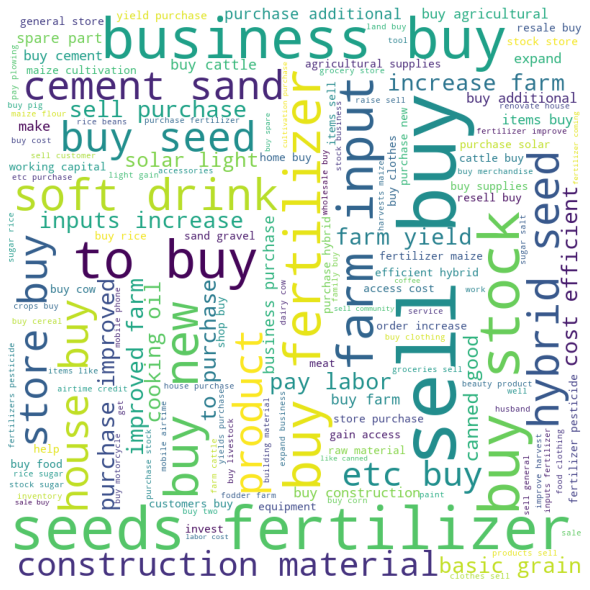

In [23]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stop_words, 
                min_font_size = 10).generate(final_unsuccessful)

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

print("Word clound for unsuccessful loans")
  
plt.show() 

### 3.2.2 Extracting
We will extract 4 features: Lexical Diversity, Text Length, Word Count and TF/IDF.

In [24]:
unique_words = dict()
def lexical_diversity(text):
    tokenized_text = nltk.word_tokenize(text)
    if len(tokenized_text) == 0:
        return 0
    for i in tokenized_text:
        try:
            unique_words[i] += 1
        except:
            unique_words[i] = 1
    return len(set(tokenized_text)) / len(tokenized_text)

loans_with_label['lexical_diversity'] = loans_with_label['use'].progress_apply(lexical_diversity)

100%|████████████████████████████████████████████████████████████████| 671203/671203 [01:57<00:00, 5730.26it/s]


In [25]:
loans_with_label['use_length'] = loans_with_label['use'].apply(lambda x: len(x))
loans_with_label['word_count'] = loans_with_label['use'].progress_apply(lambda x: len(nltk.word_tokenize(x)))

100%|████████████████████████████████████████████████████████████████| 671203/671203 [01:42<00:00, 6530.08it/s]


In [26]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer 

filtered_use = loans['use'].apply(lambda x: x if not pd.isna(x) else "")

tfidf_vectorizer = TfidfVectorizer(use_idf=True)
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(filtered_use)

# get the first vector out (for the first document)
first_vector_tfidfvectorizer = tfidf_vectorizer_vectors[0]

# place tf-idf values in a pandas data frame
temp_df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"])
tfidf_df = temp_df.sort_values(by=["tfidf"],ascending=False)

In [27]:
tokenizer = nltk.RegexpTokenizer(r'\w+')
def tfidf_extraction(use):
    values = []
    for i in tokenizer.tokenize(use):
        i = i.lower()
        if i not in tfidf_df.index:
            continue
        values.append(tfidf_df.loc[i].iloc[0])
    return np.array(values).max(initial=0)

loans_with_label['tfidf'] = loans_with_label['use'].progress_apply(tfidf_extraction)

100%|█████████████████████████████████████████████████████████████████| 671203/671203 [21:58<00:00, 509.17it/s]


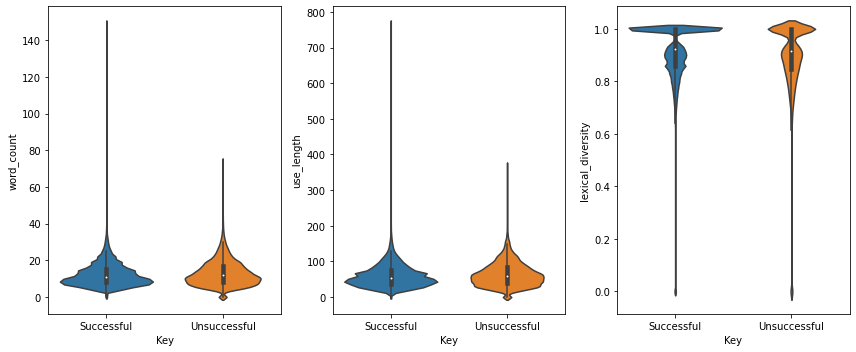

In [28]:
import seaborn as sns

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,5))

ax = sns.violinplot(x="Key", y="word_count", data=loans_with_label, ax=axes[0])
ax = sns.violinplot(x="Key", y="use_length", data=loans_with_label, ax=axes[1])
ax = sns.violinplot(x="Key", y="lexical_diversity", data=loans_with_label, ax=axes[2])

plt.tight_layout()
plt.show()

#### Results
By analyzing the prior charts, the successful loans seem to have a shorter but richer sentence in the use field.

## 3.3 Posted date extraction
The dataset has 3 different date columns. Posted, funded and disbursed. <br>
- Funded time is not useable because has 100% correlation with our labal (If a fund hasn't been fully funded, it won't have funded time)
- Disbursed time column has too many missing entries.
- Posted time is the only useful column, so we'll be using it for our features.

We had 2 approaches for date extraction:
1. Create boolean features for each day, month, year, day in the week (total of 31+12+5+7=55 features)
2. Adding 4 numeric features (day, month, year, day in the week)
While the first method might assist with find a better correlation, it is much longer to extract and to compute, and probably won't yield a significant difference.
The second is quicker and easier, and we are not losing any data.

In [29]:
from datetime import datetime
def time_to_feature(date_):
    date_ = datetime.strptime(date_, "%Y-%m-%d %H:%M:%S+00:00")
    return pd.Series({"posted_year": date_.year, "posted_month": date_.month, "posted_day": date_.day, "posted_weekday": date_.weekday(), "posted_hour": date_.hour})

posted_time_series = loans_with_label['posted_time'].progress_apply(time_to_feature)

100%|████████████████████████████████████████████████████████████████| 671203/671203 [07:49<00:00, 1428.78it/s]


In [30]:
# posted_time_series = posted_time_series.rename(columns={0:"posted_year", 1:"posted_month", 2:"posted_day", 3:"posted_weekday", 4:"posted_hour"})
# 
loans_with_label = loans_with_label.merge(posted_time_series, left_index=True, right_index=True)
# successful_with_mpi_df = successful_with_mpi_df.merge(named_posted_time_successful, left_index=True, right_index=True)

## 3.4 Tags
The tags column contains one cell for each loan entry. This single cell might contain more than one tag, in order to use this data we'll have to create a feature for each different tag that exists in dataset set. <br>
The Tags column might be useful, so we will have to preprocess it.<br>
This section adds tags as independent columns. It takes a while to compute.

### 3.4.1 Tags preprocessing

In [31]:
def get_tag_list(tags):
    stags = set()
    if type(tags) != str:
        return set()
    tags = tags.split(",")
    for tag in tags:
        tag = tag.strip("# '")
        stags.add(tag)
    return stags

all_tags = set()
for tags in loans.tags:
    all_tags.update(get_tag_list(tags))
print(f'Total tags obtained: {len(all_tags)}')

loans_with_label['tag_list'] = loans_with_label.apply(lambda r: get_tag_list(r['tags']), axis=1)

Total tags obtained: 35


### 3.4.2 Tags extraction

In [32]:
# print(f'Finished: ', end='')
for tag in tqdm(all_tags):
    loans_with_label[f'{tag}_tag'] = loans_with_label.apply(lambda r: tag in r['tag_list'], axis=1)
#     print(f'{tag}, ', end='')
    

100%|██████████████████████████████████████████████████████████████████████████| 35/35 [12:27<00:00, 21.37s/it]


### 3.4.3 Tags selection

In [33]:
tag_names = [tag + '_tag' for tag in all_tags]
tags_df = pd.DataFrame(index=tag_names, columns =['successful', 'unsuccessful'])
appearance_tags_df = pd.DataFrame(columns =['successful', 'unsuccessful'])
successful_with_tags = loans_with_label.query("Key == 'Successful'")
unsuccessful_with_tags = loans_with_label.query("Key == 'Unsuccessful'")
for tag in tag_names:    
    sudf_num = int(successful_with_tags[successful_with_tags[tag] == 1].count().iloc[0] / successful_with_tags.count().iloc[0] * 100)
    undf_num = int(unsuccessful_with_tags[unsuccessful_with_tags[tag] == 1].count().iloc[0] / unsuccessful_with_tags.count().iloc[0] * 100)
    tags_df.loc[tag] = [sudf_num, undf_num]
    if sudf_num != 0 or undf_num != 0:
        appearance_tags_df.loc[tag] = [sudf_num, undf_num]


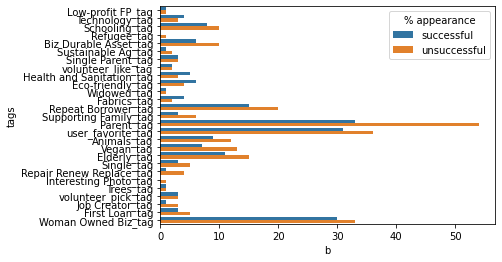

In [34]:
appearance_tags_df.index.name = 'tags'
tags_df_melted = appearance_tags_df.reset_index().melt(var_name='% appearance', value_name='b', id_vars=['tags'])
ax = sns.barplot(y='tags', x='b', hue='% appearance', data=tags_df_melted)

In [35]:
# tag_names = [tag + '_tag' for tag in all_tags]+['has_female', 'has_male']
# view_tags = loans_with_label[tag_names+["Key"]]
# sns.barplot(x=view_tags.columns, data=view_tags, hue="Key", estimator=lambda x: x==True)

### 3.4.4 Different tag versions
We tried out all the versions below, but the third one has gained the best results - using only 'user_favorite' tag.

In [36]:
#tags_selected = ['Vegan_tag', 'Elderly_tag', 'Woman Owned Biz_tag', 'Schooling_tag', 'Animals_tag', 'user_favorite_tag', 'Parent_tag', 'Repeat Borrower_tag']
# tags_selected = ['user_favorite_tag', 'Parent_tag', 'Repeat Borrower_tag', 'Woman Owned Biz_tag']
tags_selected = ['user_favorite_tag']

## 3.5 Additional Features
So far we've proccessed the data in order for it to be usable as a feature. <br>
Now, let's look at the rest of the data and see how usful it can be for our prediction <br>
These plots are ment to give as a glimpse at how this data might affects our model <br>
The plots shows the ratio of a certain feature within successful or unsuccessful entries.

### 3.5.1 Loan amount

#### 3.5.1.1 Sectors
Here we get an impression of which loan sectors are more likely to be funded. <br>
The ratios seem to be even among successful and unsuccessful loans, but some field seem to be more likely to be more successful (Personal use, Education and food).

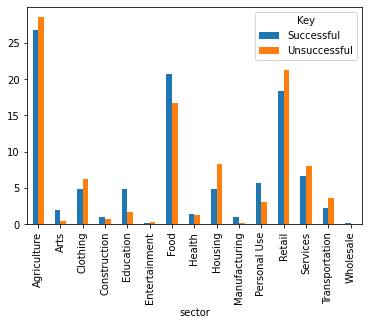

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

sectors = loans.sector.unique()

sector_loans_df = loans_with_label.groupby(["sector", "Key"]).size().unstack("Key")
sector_loans_df["Successful"] = sector_loans_df["Successful"].apply(lambda x: x / len(successful_loans_df) * 100)
sector_loans_df["Unsuccessful"] = sector_loans_df["Unsuccessful"].apply(lambda x: x / len(unsuccessful_loans_df) * 100)
sector_loans_df.plot(kind="bar")


#### 3.5.1.2 Loan amount by sector

Lets take a look at average loan amount per sector of successful and unsuccesful loans. <br>
This box plot gives join the sector and the loan amount that we looked at previously.

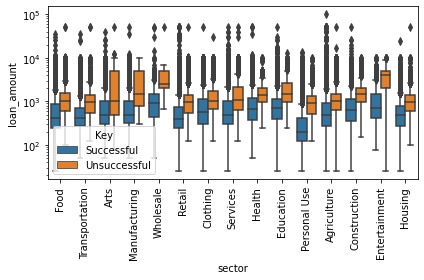

In [38]:

ax = sns.boxplot(x="sector", y="loan_amount", data=loans_with_label, hue="Key")
ax.set_yscale("log")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()

We can see that for each sector, the average loan amount is greater on unsuccessful loans. We can also see which sector requests for higher loans, and what is the average request that succeeds (for each sector). 

#### 3.5.1.3 Loan amount
On average, unsuccessful loans request for higher amounts

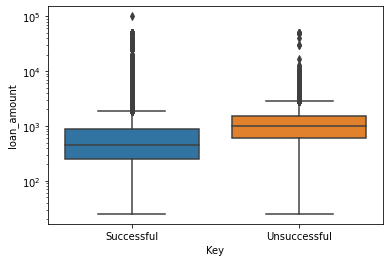

In [39]:
ax = sns.boxplot(x="Key", y="loan_amount", data=loans_with_label)
# ax.set_xticklabels(["Successful", "Unsuccessful"])
ax.set_yscale('log')
plt.show()

### 3.5.2 Other
#### 3.5.2.1 Term in months
We can see here that on average, unsuccessful loans request for a longer term to return the loans.

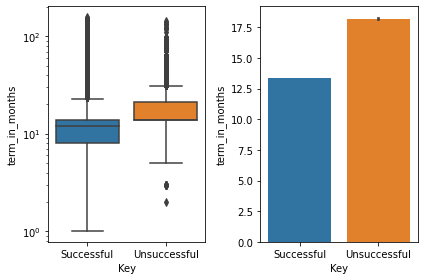

In [40]:
plt.subplot(1, 2, 1)
ax = sns.boxplot(x="Key", y="term_in_months", data=loans_with_label)
ax.set_yscale('log')
plt.subplot(1, 2, 2)
ax = sns.barplot(x="Key", y="term_in_months", data=loans_with_label)

plt.tight_layout()
plt.show()

#### 3.5.2.2 Repayment interval
Most of the unsuccessful loans have monthly repayment interval, while almost 50% of the successful loans have irregular interval. It seems a bit odd, since borrowers might prefer a safer repayment method, but this is probably a classic case of causation != correlation. There's probably a probably different cause for this diff on the interval rate, but nevertheless it can be a useful feature.

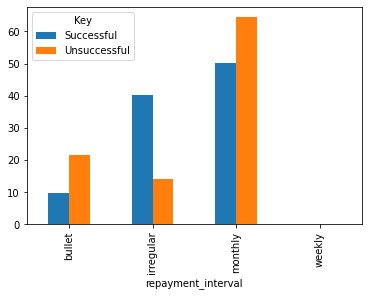

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

repayment_intervals = loans_with_label.repayment_interval.unique()


loans_by_repayment = loans_with_label.groupby(["Key", "repayment_interval"]).size().unstack("Key")
loans_by_repayment["Successful"] = loans_by_repayment["Successful"].apply(lambda x: x / len(successful_loans_df) * 100)
loans_by_repayment["Unsuccessful"] = loans_by_repayment["Unsuccessful"].apply(lambda x: x / len(unsuccessful_loans_df) * 100)
loans_by_repayment.plot(kind="bar")

#### 3.5.2.3 MPI

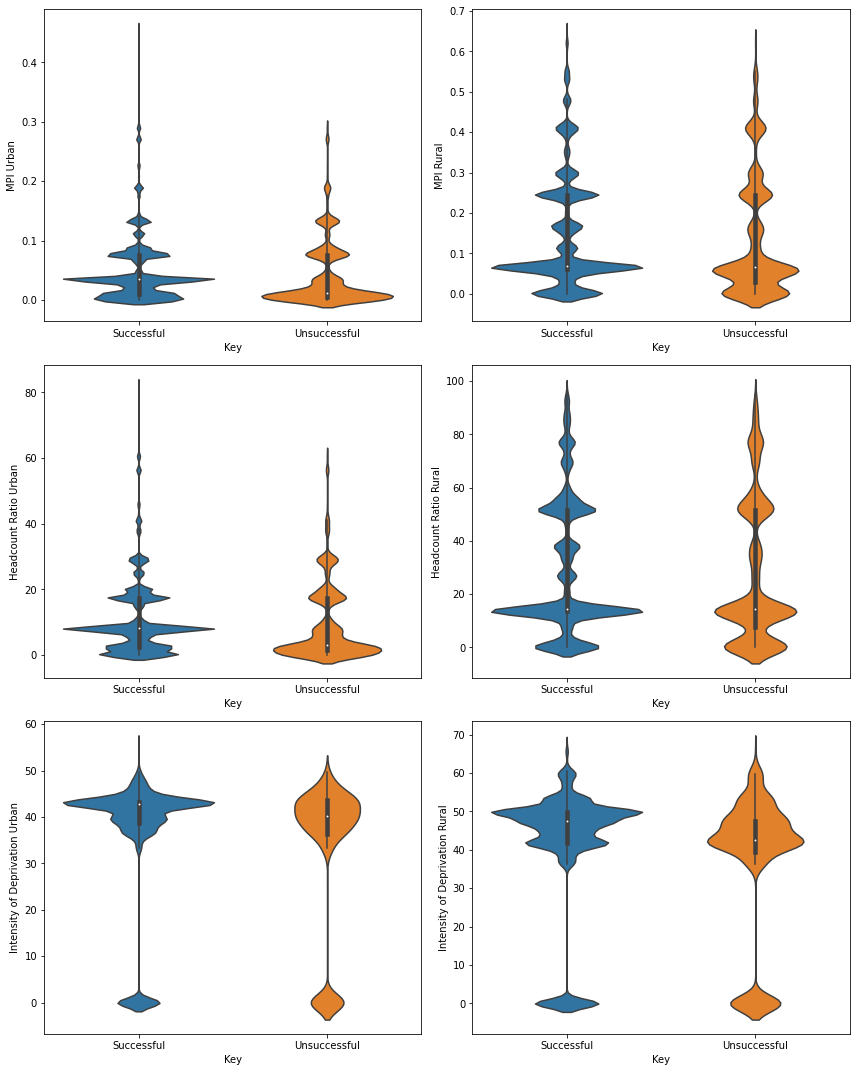

In [42]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,15))

ax = sns.violinplot(x="Key", y="MPI Urban", data=loans_with_label, ax=axes[0, 0])
ax = sns.violinplot(x="Key", y="MPI Rural", data=loans_with_label, ax=axes[0, 1])
ax = sns.violinplot(x="Key", y="Headcount Ratio Urban", data=loans_with_label, ax=axes[1, 0])
ax = sns.violinplot(x="Key", y="Headcount Ratio Rural", data=loans_with_label, ax=axes[1, 1])
ax = sns.violinplot(x="Key", y="Intensity of Deprivation Urban", data=loans_with_label, ax=axes[2, 0])
ax = sns.violinplot(x="Key", y="Intensity of Deprivation Rural", data=loans_with_label, ax=axes[2, 1])

plt.tight_layout()
plt.show()

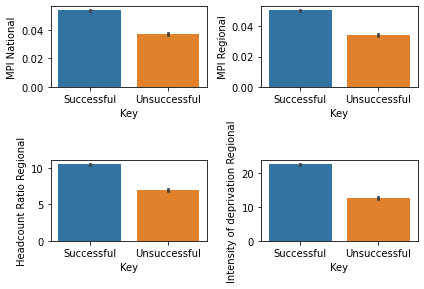

In [43]:
plt.subplot(2, 2, 1)
ax = sns.barplot(x="Key", y="MPI National", data=loans_with_label)
plt.subplot(2, 2, 2)
ax = sns.barplot(x="Key", y="MPI Regional", data=loans_with_label)
plt.subplot(2, 2, 3)
ax = sns.barplot(x="Key", y="Headcount Ratio Regional", data=loans_with_label)
plt.subplot(2, 2, 4)
ax = sns.barplot(x="Key", y="Intensity of deprivation Regional", data=loans_with_label)
plt.tight_layout()
plt.show()

These plots show the MPI information of successful and unsuccessful loans. <br>
The pattern is that the MPI index is greater among the successful loans, on average, for both the regional MPI and National MPI. <br>
This means, that most of the successful loans are aimed toward countries with higher MPI index (or in other words, the people who needs the loans the most)


## 3.6 Selected Features

These dataframes (undf, sudf) will be used for the final composition of the data set.

In [44]:
selected_features_df = loans_with_label.loc[:, ['Key',
    'loan_amount', 'sector', 'activity', 'term_in_months', 'repayment_interval', 
    'MPI Urban', 'Headcount Ratio Urban', 'Intensity of Deprivation Urban', 'MPI Rural', 'Headcount Ratio Rural',
    'Intensity of Deprivation Rural', 'partner_id', 'country_code', 'borrowers_amount', 'has_male', 'has_female',
    'posted_year','posted_month', 'posted_day', 'posted_weekday', # 'posted_hour', 
    'lexical_diversity', 'use_length', 'word_count',  'lender_count', 
    'MPI National', 'MPI Regional', 'Headcount Ratio Regional', 'Intensity of deprivation Regional', 
    'tfidf',
] + tags_selected]
print(f'number of features: {len(selected_features_df.columns)}')

number of features: 31


In [45]:
selected_features_df.groupby("Key").size()

Key
Successful      622875
Unsuccessful     48328
dtype: int64

#  <a class="anchor" id="encoding">4. Encoding</a>
We have some other relevant features to be encoded before we can use them.

## 4.1 Encoding Features
Now we will encode the feature on the whole dataset.

In [46]:
from sklearn.preprocessing import LabelEncoder

sector_le = LabelEncoder()
activity_le = LabelEncoder()
pay_int_le = LabelEncoder()
country_code_le = LabelEncoder()
has_male_le = LabelEncoder()
has_female_le = LabelEncoder()

In [47]:
country_code_le.fit(selected_features_df['country_code'])

sector_le.fit(selected_features_df['sector'].unique())
activity_le.fit(selected_features_df['activity'].unique())
pay_int_le.fit(selected_features_df['repayment_interval'])
selected_features_df['sector'] = sector_le.transform(selected_features_df['sector'])
has_male_le.fit(selected_features_df['has_male'])
has_female_le.fit(selected_features_df['has_female'])

selected_features_df['activity'] = activity_le.transform(selected_features_df['activity'])
selected_features_df['repayment_interval'] = pay_int_le.transform(selected_features_df['repayment_interval'])
selected_features_df['country_code'] = country_code_le.transform(selected_features_df['country_code'])
selected_features_df['has_male'] = has_male_le.transform(selected_features_df['has_male'])
selected_features_df['has_female'] = has_male_le.transform(selected_features_df['has_female'])

for tag in tags_selected:
    le = LabelEncoder()
    le.fit(selected_features_df[tag])
    selected_features_df[tag] = le.transform(selected_features_df[tag])

In [48]:
selected_features_df.describe()

,loan_amount,sector,activity,term_in_months,repayment_interval,MPI Urban,Headcount Ratio Urban,Intensity of Deprivation Urban,MPI Rural,Headcount Ratio Rural,...,lexical_diversity,use_length,word_count,lender_count,MPI National,MPI Regional,Headcount Ratio Regional,Intensity of deprivation Regional,tfidf,user_favorite_tag
count,671203.000000,671203.000000,671203.000000,671203.000000,671203.000000,671203.000000,671203.000000,671203.000000,671203.000000,671203.000000,...,671203.000000,671203.000000,671203.000000,671203.000000,671203.000000,671203.000000,671203.000000,671203.000000,671203.000000,671203.000000
mean,842.394551,5.840761,75.634879,13.738981,1.407017,0.046761,10.589539,36.754088,0.145237,29.032321,...,0.912354,59.824171,12.168618,20.590842,0.052395,0.049415,10.220522,21.811282,0.182952,0.320526
std,1198.658844,4.534490,38.757050,8.598880,0.673720,0.051510,10.916181,13.900039,0.138478,25.113439,...,0.112216,30.075249,6.107292,28.459485,0.088880,0.081469,15.970894,23.644525,0.053964,0.466679
min,25.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,275.000000,0.000000,57.000000,8.000000,1.000000,0.010000,2.400000,38.600000,0.061000,13.670000,...,0.857143,38.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.172717,0.000000
50%,500.000000,6.000000,72.000000,13.000000,2.000000,0.035000,8.100000,42.700000,0.068000,14.440000,...,0.923077,54.000000,11.000000,13.000000,0.000000,0.000000,0.000000,0.000000,0.172717,0.000000
75%,1000.000000,11.000000,112.000000,14.000000,2.000000,0.076000,17.300000,43.300000,0.245000,51.440000,...,1.000000,76.000000,15.000000,24.000000,0.052000,0.055000,11.600000,48.300000,0.172717,1.000000
max,100000.000000,14.000000,162.000000,158.000000,3.000000,0.459000,82.500000,55.700000,0.651000,96.920000,...,1.000000,772.000000,150.000000,2986.000000,0.557000,0.594000,93.000000,65.600000,0.646336,1.000000


## 4.2  Biased encoding
On our previous attempt we separated the label using different dataframes (we didn't merge unsuccessful_loans_df and successful_loans_df). When we applied and proccesed the features, we've done the processing for both the dataframes. <br>
Eventually, when we reached the encoding, we had to encode them separatly as well. Since we've encoded the succeessful and unsuccessful entries one after the other, our encoded data had biased value. <br>
The data was biased because some of the encoded value existed only in one of the datasets, so the DNN could classify the data with a great success rate using only the encoded data. <br>
With the biased encdoing we've reached success rate of 99%...

#  <a class="anchor" id="models">5. Models</a>
## 5.1 Introduction


### 5.1.1 POC SGDClassifier (initial model)
The first model we trained for the proposal of this notebook was SGDClassifier. The results weren't very promising, they are presented here as a reference:<br>
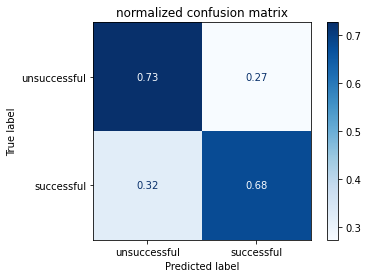
<br>


### 5.1.2 Further Models
We continued the research and trained an MLPClassifier (DNN model) and gained much better results! 
We have 1 SGD model and 3 DNN models. 
- DS1 - The SGD simply includes all of our extracted features, and we'll be able to see the improvement from the POC
- DS2 - The first DNN was trained on the same dataset as the last SGDClassifier, and does not include regional MPI data. We wanted to compare the results of a DNN and an SGD models, without changing the data or the features.
- DS3 - The second DNN is the same as the first one, but we tried to deal with the unbalanced dataset using oversampling. It should be compared to DS2.
- DS4 - In this model, we tried to deal with the imbalanced data by building imbalanced datasets. The successful loans amount in the training set is double in size, compared to the unsuccessful loans amount.
- DS5 - The last DNN includes the regional MPI features. Except that, it was trained on the same dataset as the first DNN model, so it should be compared to DS2.

The models, including composition, training and testing, are presented below.


In [49]:
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

### 5.1.3 Randomizing and initial sizes

In [50]:
# selected_features_df = selected_features_df.sample(frac=1).reset_index(drop=True)
sudf_main = selected_features_df.query("Key == 'Successful'").drop(["Key"], axis=1)
undf_main = selected_features_df.query("Key == 'Unsuccessful'").drop(["Key"], axis=1)
sudf_main = sudf_main.sample(frac=1).reset_index(drop=True)
undf_main = undf_main.sample(frac=1).reset_index(drop=True)
print(f'amount of successful loans: {len(sudf_main)}')
print(f'amount of unsuccessful loans: {len(undf_main)}')

amount of successful loans: 622875
amount of unsuccessful loans: 48328


As we can see here, the data isn't balanced. We present here 3 possible solutions, solutions 1+2 will be exemplified as DS2 and DS3 correspondingly:
1. <b>reducing the succesful samples</b> - since there are less unsuccessful samples, an appropriate approach is not to use all the successful loans data.
2. <b>oversampling</b> - duplication of existing unsuccessful samples in order to enlarge the data set size.
3. <b>using imbalance datasets</b> - using data "as-is", by that taking more successful loans than unsuccessful loans. The simplest approach, but might lead to biases (the results were bad, so won't be presented here).

## 5.2 Extended SGDClassifier (DS1)
The extended SGDClassifier model includes all the features we have seen above in the feature engineering process. We've added dozens of features, which lead to much better results than the POC model.<br>
To make it clear - this model is the same one as the SGDClassifier in the POC, except the features we've added, which improved the results.

### 5.2.1 Composition
Since there are less unsuccessful loans, we took 2/3 of them for training and corresponding amount from the sucesssful loans. The rest (a third of the unsuccessful and a corresponding amount of the successful) will be used for test.<br>

In [51]:
sudf = sudf_main.drop(['MPI National', 'MPI Regional', 'Headcount Ratio Regional', 'Intensity of deprivation Regional'], axis=1)
undf = undf_main.drop(['MPI National', 'MPI Regional', 'Headcount Ratio Regional', 'Intensity of deprivation Regional'], axis=1)

# take only 2/3 of the data for training (based on undf size, since undf is 39,878 and sudf is 550,560)
count = int(len(undf) * 2 / 3)
print(f'size of training set (successful and unsuccessful): {count*2}')
Y = []
Y.extend(np.zeros(count)) # for unsuccessful loans - undf
Y.extend(np.ones(count)) # for successful loans - sudf
Y = np.array(Y)
X = pd.concat([undf[:count], sudf[:count]], ignore_index=True)

# predict test set - 1/3 of the undf data, or 1/2 of the training set
end_test_set_count = int(3*count/2) + 1
print(f'size of test set (successful and unsuccessful): {count}')

X_test = pd.concat([undf[count:], sudf[count:end_test_set_count]], ignore_index=True).reset_index(drop=True)
y_test = np.concatenate((np.zeros(int(count/2)+1), np.ones(int(count/2)+1)))

size of training set (successful and unsuccessful): 64436
size of test set (successful and unsuccessful): 32218


### 5.2.2 Training

In [52]:
from sklearn.linear_model import SGDClassifier

classifier = SGDClassifier(max_iter=1000)
clf = make_pipeline(StandardScaler(),classifier)
clf.fit(X, Y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier())])

### 5.2.3 Testing

[[0.7874612  0.2125388 ]
 [0.12073246 0.87926754]]


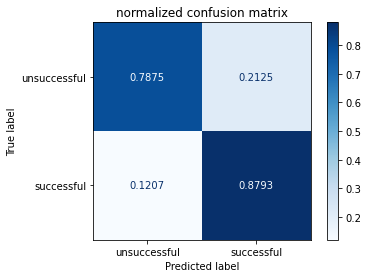

In [53]:
from sklearn.metrics import plot_confusion_matrix

disp = plot_confusion_matrix(clf, X_test, y_test,
                             display_labels=['unsuccessful','successful'],
                             cmap=plt.cm.Blues,
                             normalize='true',
                            values_format='.4g')
disp.ax_.set_title('normalized confusion matrix')
print(disp.confusion_matrix)

## 5.3 Basic MLPClassifier (DS2)
We use here the same data sets (composition, features) as we used for the Extended SGDClassifier, so we can compare the results of MLP against SGD.<br>
The data was not oversampled. Also, it doesn't include any new features.

### 5.3.1 Composition
Same as the Extended SGDClassifier.

In [54]:
sudf = sudf_main.drop(['MPI National', 'MPI Regional', 'Headcount Ratio Regional', 'Intensity of deprivation Regional'], axis=1)
undf = undf_main.drop(['MPI National', 'MPI Regional', 'Headcount Ratio Regional', 'Intensity of deprivation Regional'], axis=1)

In [55]:
# take only 2/3 of the data for training (based on undf size, since undf is 39,878 and sudf is 550,560)
count = int(len(undf) * 2 / 3)
print(f'size of training set (successful and unsuccessful): {count*2}')
Y = []
Y.extend(np.zeros(count)) # for unsuccessful loans - undf
Y.extend(np.ones(count)) # for successful loans - sudf
Y = np.array(Y)
X = pd.concat([undf[:count], sudf[:count]], ignore_index=True)

# predict test set - 1/3 of the undf data, or 1/2 of the training set
end_test_set_count = int(3*count/2) + 1
print(f'size of test set (successful and unsuccessful): {count}')

X_test = pd.concat([undf[count:], sudf[count:end_test_set_count]], ignore_index=True).reset_index(drop=True)
y_test = np.concatenate((np.zeros(int(count/2)+1), np.ones(int(count/2)+1)))


size of training set (successful and unsuccessful): 64436
size of test set (successful and unsuccessful): 32218


### 5.3.2 Training

In [56]:
classifier = MLPClassifier(max_iter=500, hidden_layer_sizes=(15, 15, 15))
clf = make_pipeline(StandardScaler(),classifier)
clf.fit(X, Y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpclassifier',
                 MLPClassifier(hidden_layer_sizes=(15, 15, 15), max_iter=500))])

### 5.3.3 Testing

[[0.92631906 0.07368094]
 [0.08541279 0.91458721]]


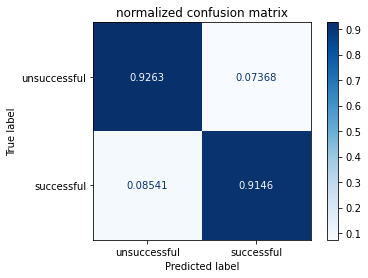

In [57]:
from sklearn.metrics import plot_confusion_matrix

disp = plot_confusion_matrix(clf, X_test, y_test,
                             display_labels=['unsuccessful','successful'],
                             cmap=plt.cm.Blues,
                             normalize='true',
                            values_format='.4g')
disp.ax_.set_title('normalized confusion matrix')
print(disp.confusion_matrix)


### 5.3.4 Results Analysis
The results on the first test set are much better than the Extended SGDClassifier model (DS1). From now on, we will present only MLP models.

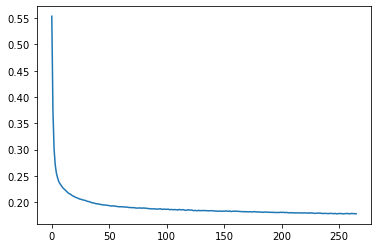

In [58]:
plt.plot(classifier.loss_curve_)

### 5.3.4 Testing the remaining successful loans
Since we don't use all the successful loans, we can utilize the rest as another benchmark on successful loans solely. The results are pretty impressive.

[[0.         0.        ]
 [0.08514078 0.91485922]]


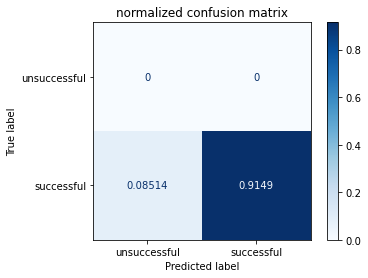

In [59]:
X_success_test = sudf[count:].reset_index(drop=True)
y_success_test = np.ones(len(X_success_test))

disp = plot_confusion_matrix(clf, X_success_test, y_success_test,
                             display_labels=['unsuccessful','successful'],
                             cmap=plt.cm.Blues,
                             normalize='true',
                            values_format='.4g')
disp.ax_.set_title('normalized confusion matrix')
print(disp.confusion_matrix)


## 5.4 Oversampled MLPClassifier (DS3)

This dataset involves a technique called oversampling. Since we have less unsuccessful data, we'd like to oversample the existing data. That way, we can use more unique successful data, and enlarge the general size of the data set.<br>

### 5.4.1 Composition
For this training cycle, we split the unsuccessful loans again into two parts:<br>
* two thirds - for training (to be oversampled)
* a third - for testing
<br>

We took a corresponding amount of successful loans for both training and test sets.

In [60]:
from collections import Counter

# undf - take only 2/3 of the data for training
sudf_training_count = int(len(sudf) * 2 / 3)
undf_training_count = int(len(undf) * 2 / 3)

# predict test set - 1/3 of the undf data
sudf_test_count = int(len(sudf) / 3)
undf_test_count = int(undf_training_count / 2)

# print(f'size of training set (successful and unsuccessful): {count*2}')
Y_to_re = []
Y_to_re.extend(np.zeros(undf_training_count)) # for unsuccessful loans - undf
Y_to_re.extend(np.ones(sudf_training_count)) # for successful loans - sudf
Y_to_re = np.array(Y_to_re)
X_to_re = pd.concat([undf[:undf_training_count], sudf[:sudf_training_count]], ignore_index=True)
print(f'size of training (x): {len(X_to_re)}, size of training label (Y): {len(Y_to_re)}')

test_undf = undf[-undf_test_count:]
test_sudf = sudf[-undf_test_count:]
X_test_to_re = pd.concat([test_undf, test_sudf], ignore_index=True).reset_index(drop=True)
Y_test_to_re = np.concatenate((np.zeros(undf_test_count), np.ones(undf_test_count)))
print(f'size of test (x): {len(X_test_to_re)}, size of test label (Y): {len(Y_test_to_re)}')

print(Counter(Y_to_re))

size of training (x): 447468, size of training label (Y): 447468
size of test (x): 32218, size of test label (Y): 32218
Counter({1.0: 415250, 0.0: 32218})


### 5.4.2 Oversampling
Here we extend the unsuccessful loans to be the same size as the successful loans, using oversampling.

In [61]:
from imblearn.over_sampling import SMOTE

X_resampled, Y_resampled = SMOTE(sampling_strategy='minority').fit_resample(X_to_re,Y_to_re)
print(f'new size of training samples (x): {len(X_resampled)}, training labeled (Y): {len(Y_resampled)}')

print(Counter(Y_resampled))

new size of training samples (x): 830500, training labeled (Y): 830500
Counter({0.0: 415250, 1.0: 415250})


### 5.4.3 Training

In [62]:
# train a model
classifier_resampling = MLPClassifier(max_iter=500, hidden_layer_sizes=(15, 15, 15))
clf_resampling = make_pipeline(StandardScaler(),classifier_resampling)
clf_resampling.fit(X_resampled, Y_resampled)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpclassifier',
                 MLPClassifier(hidden_layer_sizes=(15, 15, 15), max_iter=500))])

### 5.4.4 Testing

[[0.87143833 0.12856167]
 [0.05344838 0.94655162]]


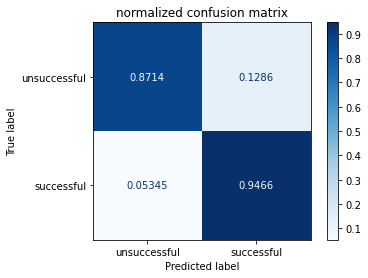

In [63]:
# predict test set
from sklearn.metrics import plot_confusion_matrix
disp = plot_confusion_matrix(clf_resampling, X_test_to_re, Y_test_to_re,
                             display_labels=['unsuccessful','successful'],
                             cmap=plt.cm.Blues,
                             normalize='true',
                            values_format='.4g')
disp.ax_.set_title('normalized confusion matrix')
print(disp.confusion_matrix)



### 5.4.5 Results Analysis
The results (compared to the Basic MLPClassifier) on the successful loans remain the same. However, the unsuccessful loans seem to be worse. The oversampling might be too aggressive, or it might just not be the right solution to the problem.

### 5.4.6 Another oversampled model
In order to test our hypothesis, we trained another oversampled model, but only x2 for the unsuccessful loans (instead of x12 in the last one).<br>
The results indicate our hypothesis. The successful loans seem to be better than the Basic MLPClassifier, but worse than the first oversampled model. The same results work for the unsuccessful loans.<br>
The bottom line is that we find here a correlation between the uniqueness of the data and the results we achieve on it (oversampled data -> worse results, unique data -> better results).

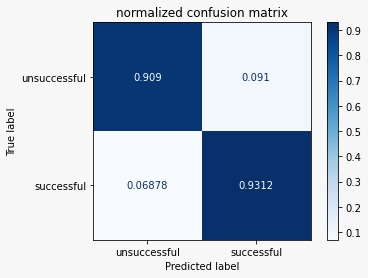

## 5.5 Imbalanced MLPClassifier (DS4)
This model was trained with imbalanced data sets. We took the unsuccessful data as is, and added to the training set a double amount of successful data.

### 5.5.1 Composition

In [64]:
from collections import Counter

# undf - take only 2/3 of the data for training
undf_training_count = int(len(undf) * 2 / 3)

# predict test set - 1/3 of the undf data
undf_test_count = int(len(undf) / 3)

# print(f'size of training set (successful and unsuccessful): {count*2}')
Y_imb = []
Y_imb.extend(np.zeros(undf_training_count)) # for unsuccessful loans - undf
Y_imb.extend(np.ones(undf_training_count*2)) # for successful loans - sudf
Y_imb = np.array(Y_imb)
X_imb = pd.concat([undf[:undf_training_count], sudf[:undf_training_count*2]], ignore_index=True)
print(f'size of training (x): {len(X_imb)}, size of training label (Y): {len(Y_imb)}')

test_undf_imb = undf[undf_training_count:]
test_sudf_imb = sudf[:-len(test_undf_imb)]
X_test_imb = pd.concat([test_undf_imb, test_sudf_imb], ignore_index=True).reset_index(drop=True)
Y_test_imb = np.concatenate((np.zeros(len(test_undf_imb)), np.ones(len(test_sudf_imb))))
print(f'size of test (x): {len(X_test_imb)}, size of test label (Y): {len(Y_test_imb)}')

print(Counter(Y_imb))

size of training (x): 96654, size of training label (Y): 96654
size of test (x): 622875, size of test label (Y): 622875
Counter({1.0: 64436, 0.0: 32218})


### 5.5.2 Training

In [65]:
# train a model
classifier_imb = MLPClassifier(max_iter=500, hidden_layer_sizes=(15, 15, 15))
clf_imb = make_pipeline(StandardScaler(),classifier_imb)
clf_imb.fit(X_imb, Y_imb)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpclassifier',
                 MLPClassifier(hidden_layer_sizes=(15, 15, 15), max_iter=500))])

### 5.5.3 Testing

[[0.9014526  0.0985474 ]
 [0.05186542 0.94813458]]


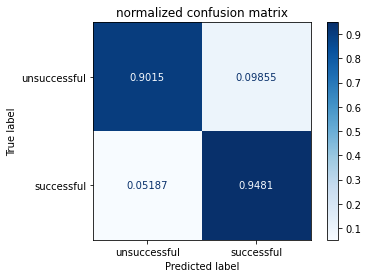

In [66]:
# predict test set
from sklearn.metrics import plot_confusion_matrix
disp = plot_confusion_matrix(clf_imb, X_imb, Y_imb,
                             display_labels=['unsuccessful','successful'],
                             cmap=plt.cm.Blues,
                             normalize='true',
                            values_format='.4g')
disp.ax_.set_title('normalized confusion matrix')
print(disp.confusion_matrix)

### 5.5.4 Results Analysis
The imbalanced model is proved to be similar to the Basic MLPClassifier. We have worse prediction on the unsuccessful loans by 3%, but better prediction on the successful loans by 3% as well.

## 5.6 Regional MPI MLPClassifier (DS5)
For this model training, we partially extracted the regional data from MPI. We extracted a large portion of the regions, and after seeing the initial results we concluded that this direction does not improve.<br>
We've filled MPI, head count and Intensity with 0s. <br>
Please note that the name is "regional MPI" and not just "MPI", since the country MPI data is already included in all the previous models. Here we add the regional MPI data.


### 5.6.1 Preprocessing - Merge Regional MPI

### Filter Columns

In [67]:
undf1 = undf_main
sudf1 = sudf_main

### Prepare train and test samples

In [68]:
# take only 2/3 of the data for training (based on undf size, since undf is 39,878 and sudf is 550,560)
count = int(len(undf1) * 2 / 3)
print(f'size of training set (successful and unsuccessful): {count*2}')
Y = []
Y.extend(np.zeros(count)) # for unsuccessful loans - undf
Y.extend(np.ones(count)) # for successful loans - sudf
Y = np.array(Y)
X = pd.concat([undf1[:count], sudf1[:count]], ignore_index=True)

# predict test set - 1/3 of the undf data, or 1/2 of the training set
end_test_set_count = int(3*count/2) + 1
print(f'size of test set (successful and unsuccessful): {count}')

X_test = pd.concat([undf1[count:], sudf1[count:end_test_set_count]], ignore_index=True).reset_index(drop=True)
#X_test = np.concatenate((predict_unsuc, predict_suc))
y_test = np.concatenate((np.zeros(int(count/2)+1), np.ones(int(count/2)+1)))


size of training set (successful and unsuccessful): 64436
size of test set (successful and unsuccessful): 32218


### 5.6.2 Training

In [69]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    classifier = MLPClassifier(max_iter=200, hidden_layer_sizes=(20, 20, 20,))

clf1 = make_pipeline(StandardScaler(),classifier)
clf1.fit(X, Y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpclassifier',
                 MLPClassifier(hidden_layer_sizes=(20, 20, 20)))])

### 5.6.3 Testing

[[0.93122284 0.06877716]
 [0.09087523 0.90912477]]


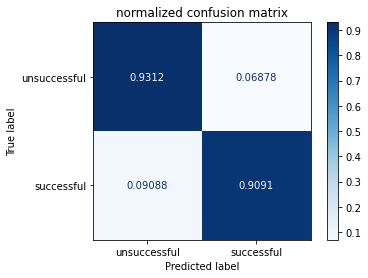

In [70]:
from sklearn.metrics import plot_confusion_matrix

disp = plot_confusion_matrix(clf1, X_test, y_test,
                             display_labels=['unsuccessful','successful'],
                             cmap=plt.cm.Blues,
                             normalize='true',
                            values_format='.4g')
disp.ax_.set_title('normalized confusion matrix')
print(disp.confusion_matrix)


### 5.6.4 Results Analysis
As we can see, the results are not better than DS2, the basic MLPClassifier.

### 5.6.5 Testing the remaining successful loans
With remaining successful loans

[[0.         0.        ]
 [0.09138806 0.90861194]]


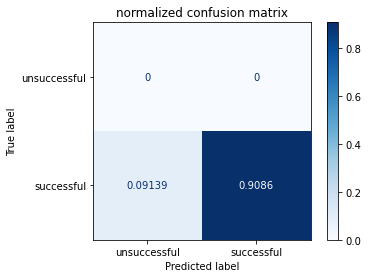

In [71]:
X_success_test = sudf1[count:].reset_index(drop=True)
y_success_test = np.ones(len(X_success_test))

disp = plot_confusion_matrix(clf1, X_success_test, y_success_test,
                             display_labels=['unsuccessful','successful'],
                             cmap=plt.cm.Blues,
                             normalize='true',
                            values_format='.4g')
disp.ax_.set_title('normalized confusion matrix')
print(disp.confusion_matrix)


# 5.7 Results
We trained a very first model as a POC (SGDClassifier). The initial results indicate that there is a case for the current classification problem, however the results were too bad.<br>
Next, we added dozens of features, based on deeper research of the data. The results of the next SGDClassifier we trained were much better. We called thie model the Extended SGDClassifier. <br>
After some research, we trained the Basic MLPClassifier which proved to be better than both of them. It conludes all the features we added to the Extended SGDClassifier.<br>
We decided to continue with the MLPClassifier, and trained a few more versions of it.
We started off by showing an oversampled model, which is called Oversampled MLPClassifier. We experienced a lower prediction of the unsuccessful loans, so we tried to lower the oversampling to x2. The results were better.<br>
Next, we showed the Imbalanced MLPClassifier. Its results were similar to the second oversampling model and the Basic MLPClassifier.<br>
Last but not least, we trained the Regional MPI MLPClassifier. Its results were similar to the Basic MLPClassifier.

# <a class="anchor" id="conclusions">6. Conclusions</a>
## 6.1 Obstacles
Along the way we had some bugs that shifted our results, the most significat bug was the biased encoding, it improved our success rate significally and we didn't suspect this bug until we reviewed some of our code. <br>
Another, less impactful bug was merging the MPI and loans dataset. We didn't set the 'how' parameter, and ended up losing 80k entries which suprisinly didn't affect the results too badly. <br><br>

## 6.2 Summary
We faced various challenges in this project: missing values, features that require preprocessing, crossing data with other datasets, dealing with imbalanced datasets, and figuring out the best model for predicting the best results. Each challange required different tools and attitude, and we presented the solutions we offered to overcome them. In some cases, we compared a few solutions.<br>
One of the biggest challanges of the project was the feature extraction, and it came into effect with the largest section of our notebook dedicated to feature extraction. The model training and fine uning was also a major challenge.<br>
Our end goal was to predicit whether a loan will get fully funded on Kiva platform or not, and we managed to get a decent result at the end. Using the 2nd (the Basic MLPClassiifer) or 5th models (Regional MPI MLPClassifier) we can get a prediction with 91% success rate whether a loan will be successful or not, using the 3rd (Oversampled MLPClassifier) or the 4th (Imbalanced MLPClassifer) model we can predict successful loans with success rate of almost 95%(!) but an unsuccessful loan with 89% success rate. <br><br>